In [121]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
import plotly
import cufflinks
plotly.__version__

'4.14.3'

In [122]:
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *


In [123]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [124]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [162]:
def optimal_portfolio(returns, n_portfolios):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = n_portfolios
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [126]:
import yfinance as yf
def dl(stock, start, end):
    subset = yf.download(stock, start=start, end=end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start:end]
    subset2 = subset[start:end]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)


In [127]:
import pandas as pd
end = pd.Timestamp.utcnow()
start = (end - 2500 * pd.tseries.offsets.BDay())
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [128]:
symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']

stocks = []
for i in symbols:
    stocks.append(dl(i,start,end))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [180]:
return_vec = np.zeros(shape=(len(stocks),len(stocks[0].iloc[:,3])-1))

for i in range(0,len(stocks)):
    intArray = np.array(np.log(1+stocks[i].iloc[:,3].pct_change().dropna()))
    return_vec[i] = intArray

log_ret = pd.DataFrame(return_vec.T)
log_ret.columns = symbols
display(log_ret)

,IBM,GLD,XOM,AAPL,MSFT,TLT,SHY
0,-0.017925,0.000239,-0.027919,-0.020643,-0.024326,0.032926,0.000095
1,0.014072,0.009987,0.018655,0.002268,0.000769,-0.012553,0.000237
2,0.018210,0.015612,0.019075,0.014142,0.019796,-0.013828,0.000118
3,-0.004924,-0.005079,-0.004321,-0.007046,-0.010610,0.001203,0.000000
4,0.005031,0.023886,0.010515,-0.001276,0.020736,0.006333,-0.000237
...,...,...,...,...,...,...,...
2404,-0.000138,0.001759,0.011643,0.013226,0.022624,0.003698,0.000232
2405,-0.006447,0.009032,-0.022908,-0.001575,0.003741,0.009221,0.000000
2406,-0.002855,-0.001744,0.011604,-0.000394,-0.000914,-0.001722,0.000232
2407,0.003064,0.000394,-0.006468,-0.012454,-0.008706,-0.004031,0.000000


Text(0, 0.5, 'returns')

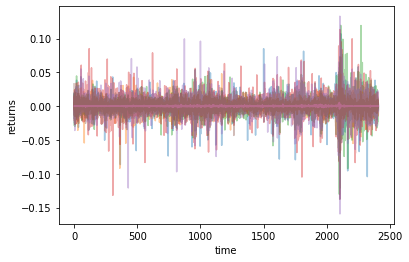

In [153]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py 
from plotly.graph_objs import *

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
#py.iplot_mpl(fig, filename='s6_damped_oscillation')

In [168]:

n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])



In [190]:
all_weights = np.zeros((n_portfolios, len(pd.DataFrame(return_vec.T).columns)))
ret_arr = np.zeros(n_portfolios)
vol_arr = np.zeros(n_portfolios)
sharpe_arr = np.zeros(n_portfolios)

for x in range(n_portfolios):
    # Weights
    weights = np.array(np.random.random(len(pd.DataFrame(return_vec.T).columns)))
    weights = weights/np.sum(weights)
    # Save weights
    all_weights[x,:] = weights
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 252.75))
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

Max sharpe ratio in the array: 1.1601938258323594
Its location in the array: 270
[0.01937547 0.02590332 0.0375749  0.20648341 0.15423849 0.31897193
 0.23745247]
Expected Annual Return: 0.10678893756430564


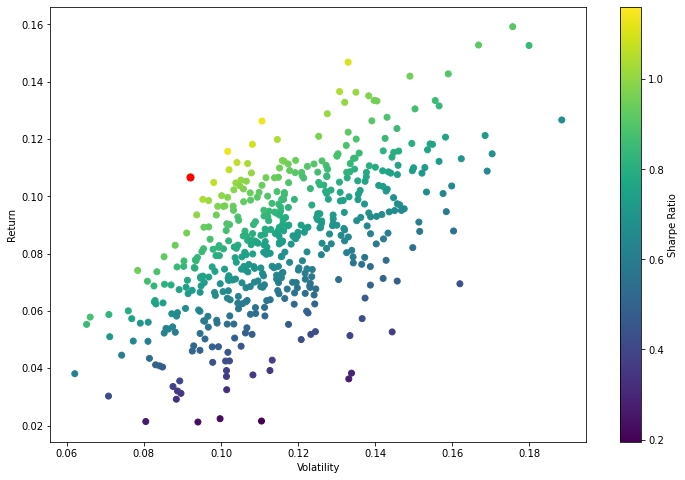

In [191]:
print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Its location in the array: {}'.format(sharpe_arr.argmax()))

print(all_weights[sharpe_arr.argmax(),:])
print('Expected Annual Return: {}'.format(ret_arr[sharpe_arr.argmax()]))
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

0.15920283356108078

In [209]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

Max sharpe ratio in the array: 1.1601938258323594
Its location in the array: 270
[0.01937547 0.02590332 0.0375749  0.20648341 0.15423849 0.31897193
 0.23745247]
Expected Annual Return: 0.10678893756430564


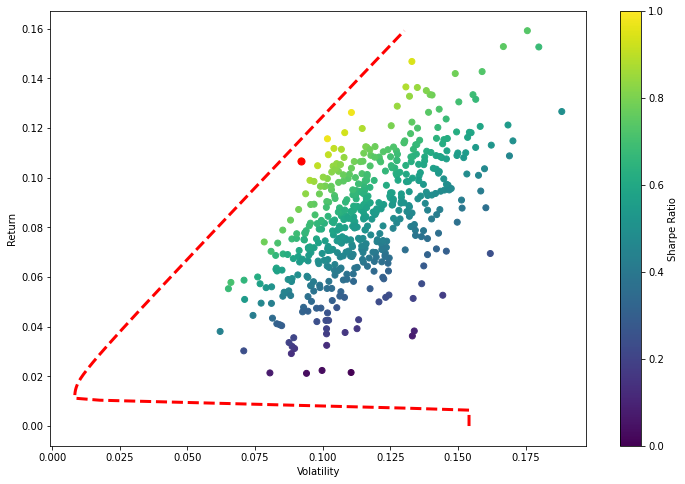

In [221]:
#https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5
#https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html
#https://stackoverflow.com/questions/63538588/python-dictionary-object-syntaxerror-expression-cannot-contain-assignment-per

from scipy.optimize import minimize 

cons = ({'type':'eq', 'fun':check_sum})
bounds = []
init_guess = []
for i in range(0,len(stocks)):
    bounds.append([0,1])
    init_guess.append(1/len(stocks))
    
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=[cons])

frontier_y = np.linspace(0,max(ret_arr),200)

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

#return, variance, sharpe ratio
get_ret_vol_sr(opt_results.x)

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

print('Max sharpe ratio in the array: {}'.format(sharpe_arr.max()))
print('Its location in the array: {}'.format(sharpe_arr.argmax()))

print(all_weights[sharpe_arr.argmax(),:])
print('Expected Annual Return: {}'.format(ret_arr[sharpe_arr.argmax()]))
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.savefig('cover.png')
plt.show()

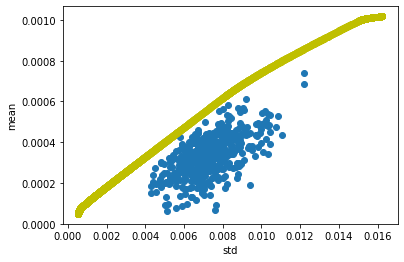

In [169]:
fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
#py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)
plt.show()



In [171]:
weights, returns, risks = optimal_portfolio(return_vec, int(n_portfolios/5))
#print(weights, returns, risks)
print(weights)


[[1.32578988e-07]
 [1.33906216e-07]
 [1.32102396e-07]
 [1.57446276e-05]
 [9.99983617e-01]
 [1.08045458e-07]
 [1.31702893e-07]]


[[1.32579027e-07]
 [1.33906246e-07]
 [1.32102430e-07]
 [1.57446268e-05]
 [9.99983617e-01]
 [1.08045422e-07]
 [1.31702921e-07]]
